# Deep learning for timeseries

## Different kinds of timeseries tasks

## A temperature-forecasting example

In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2022-11-13 17:19:13--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.137.190
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.137.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip.1’

jena_climate_2009_2 100%[===================>]  12.94M  5.15MB/s    in 2.5s    

2022-11-13 17:19:17 (5.15 MB/s) - ‘jena_climate_2009_2016.csv.zip.1’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
replace jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: jena_climate_2009_2016.csv  
replace __MACOSX/._jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Inspecting the data of the Jena weather dataset**

In [ ]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parsing the data**

In [ ]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

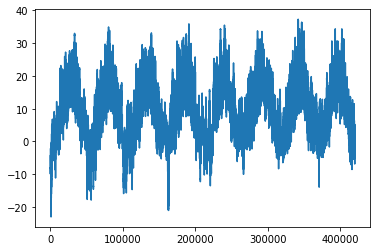

In [ ]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries** <br>
(Datenpunkte alle 10 Minuten, 10 Tage x 24 Stunden x 6 Messungen = 1440)

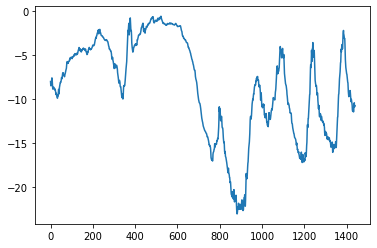

In [ ]:
plt.plot(range(1440), temperature[:1440])

**Computing the number of samples we'll use for each data split**

In [ ]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

**Normalizing the data**

In [ ]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

**Instantiating datasets for training, validation, and testing**

In [ ]:
import numpy as np
from tensorflow import keras

sampling_rate = 6 # eine Messung pro Stunde
sequence_length = 120 # 5 Tage
delay = sampling_rate * (sequence_length + 24 - 1) # delay etwas größer um eine Pause zwischen den Messungen zu haben
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [ ]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### A common-sense, non-machine-learning baseline

**Computing the common-sense baseline MAE**

In [ ]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]  # letzten gemessenen Temperaturwert (entnormalisiert)
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


### Let's try a basic machine-learning model

**Training and evaluating a densely connected model**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 38s 46ms/step - loss: 11.7132 - mae: 2.6596 - val_loss: 10.4713 - val_mae: 2.5506
Epoch 2/10
819/819 [==============================] - 39s 47ms/step - loss: 8.7649 - mae: 2.3275 - val_loss: 10.0378 - val_mae: 2.5120
Epoch 3/10
819/819 [==============================] - 39s 47ms/step - loss: 8.0488 - mae: 2.2298 - val_loss: 10.6524 - val_mae: 2.5828
Epoch 4/10
819/819 [==============================] - 40s 48ms/step - loss: 7.6096 - mae: 2.1712 - val_loss: 10.4575 - val_mae: 2.5507
Epoch 5/10
819/819 [==============================] - 39s 48ms/step - loss: 7.3392 - mae: 2.1318 - val_loss: 13.2552 - val_mae: 2.8769
Epoch 6/10
819/819 [==============================] - 39s 48ms/step - loss: 7.1230 - mae: 2.0990 - val_loss: 12.1468 - val_mae: 2.7700
Epoch 7/10
819/819 [==============================] - 38s 47ms/step - loss: 6.9531 - mae: 2.0728 - val_loss: 10.4010 - val_mae: 2.5603
Epoch 8/10
819/819 [==============================] - 

**Plotting results**

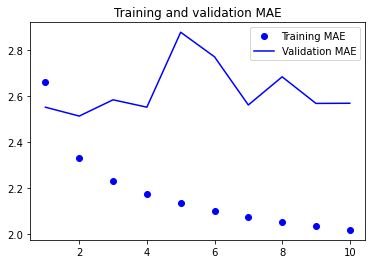

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Let's try a 1D convolutional model <br>


In [ ]:
### TO DO ###
# Einfache CNN Layer-Funktion
# layers.Conv1D(filter, kernelsize, activation)(input)
# Zwischen zwei CNN-Layern kann Pooling verwendet werden, um die Größe zu verringern
# layers.MaxPooling1D(poolsize)(input)



### A first recurrent baseline

**A simple LSTM-based model**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 48s 53ms/step - loss: 47.3758 - mae: 5.0320 - val_loss: 14.1841 - val_mae: 2.8307
Epoch 2/10
819/819 [==============================] - 43s 52ms/step - loss: 11.4662 - mae: 2.6307 - val_loss: 9.4917 - val_mae: 2.3972
Epoch 3/10
819/819 [==============================] - 43s 52ms/step - loss: 9.8763 - mae: 2.4580 - val_loss: 9.6320 - val_mae: 2.4153
Epoch 4/10
819/819 [==============================] - 43s 53ms/step - loss: 9.5077 - mae: 2.4081 - val_loss: 9.5862 - val_mae: 2.4025
Epoch 5/10
819/819 [==============================] - 42s 51ms/step - loss: 9.2394 - mae: 2.3690 - val_loss: 9.6216 - val_mae: 2.4088
Epoch 6/10
819/819 [==============================] - 43s 52ms/step - loss: 8.9701 - mae: 2.3366 - val_loss: 9.6245 - val_mae: 2.4039
Epoch 7/10
819/819 [==============================] - 43s 52ms/step - loss: 8.7322 - mae: 2.3060 - val_loss: 9.6794 - val_mae: 2.4046
Epoch 8/10
819/819 [==============================] - 43s 5

**An advanced LSTM-based model**

In [ ]:
### TO DO ###

## Advanced use of recurrent neural networks

### Using recurrent dropout to fight overfitting

**Training and evaluating a dropout-regularized LSTM**

In [ ]:
### TO DO ###
# layers.LSTM(shape, recurrent_dropout)(input)
# layers.Dropout(dropout)(input)